# Differential Power Analysis

Contrary to previous lab on leakage assessment where we had control over the key value, this session's goal is to retrieve an unknown key, used during an AES encryption. The attacker can send randomly chosen plaintexts and records power consumption. 

The first -- and quick -- part will consist in collecting traces. The second part wil introduce DPA, implement this attack and retrieve the key. The last part will give further insight into this type of attacks.

## Acquisitions
1. Communicate with the chip
2. Get a trace on the scope / Power analysis on AES
3. Get a set of (traces/plaintexts) to be attacked later

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import serial
import time

from tqdm import tnrange

In [11]:
# Install a Crypto package in the current python kernel
import sys
!{sys.executable} -m pip install Crypto
from Crypto.Cipher import AES

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/bin/python3.8 -m pip install --upgrade pip' command.


In [12]:
# connection to the chip / set up chip specific parameters
SCOPETYPE='OPENADC'
PLATFORM='CWLITEARM'
CRYPTO_TARGET='TINYAES128C' 
#CW_PATH = '../chipwhisperer/'
CW_PATH = '~/chipwhisperer/'

setup_script = CW_PATH  + "jupyter/Setup_Scripts/Setup_Generic.ipynb"
%run $setup_script

(ChipWhisperer NAEUSB WARNING|File naeusb.py:799) Your firmware (0.23) is outdated - latest is 0.65 See https://chipwhisperer.readthedocs.io/en/latest/firmware.html for more information


INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.
INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.
INFO: Found ChipWhisperer😍
scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 8556303                   to 30320963                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_fr

Next: Program the target with th AES software, identical to the leakage assessment lab (TP2).

In [13]:
# program target with software AES
cw.program_target(scope, prog, "./simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6131 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6131 bytes


### Chip communication
#### Firmware commands
The firmware consists in a simple AES-128 ciphering. There are 3 commands in the firmware:
1. `k` command + 16 bytes => set the key to this specific value 16 bytes. 
2. `p` command + 16 bytes => cipher the 16-byte message/plaintext with the key defined above.
3. `g` command + 16 bytes => cipher the 16-byte message/plaintext with an **uknown key**. This is the key you should retrieve. 

The following functions are defined and self-explicit. 



In [14]:
from time import sleep
import numpy as np
def send_key(key):
    assert type(key) is np.ndarray, "Key must be array Numpy"
    #assert all([type(octet) is np.uint8 for octet in key]), "Key must be a vector of bytes"
    assert np.shape(key) == (16,), "key length must be 16 bytes"
    assert all([0 <= octet <= 255 for octet in key]), "The value of each key byte must be between 0 and 255"
    
    target.simpleserial_write('k', bytearray(key))
    sleep(0.01)

def cipher(plain):
    assert type(plain) is np.ndarray, "Plaintext must be array Numpy"
    assert all([type(octet) is np.uint8 for octet in plain]), "Plaintext must be a vector of bytes"
    assert np.shape(plain) == (16,), "Plaintext length must be 16 bytes"
    assert all([0 <= octet <= 255 for octet in plain]), "The value of each input byte must be between 0 and 255"
    
    target.simpleserial_write('p', bytearray(plain))
    sleep(0.01)
    chiffre = target.simpleserial_read_witherrors('r', 16)
    return chiffre

def secret_cipher(plain):
    assert type(plain) is np.ndarray, "Plaintext must be array Numpy"
    assert all([type(octet) is np.uint8 for octet in plain]), "Plaintext must be a vector of bytes"
    assert np.shape(plain) == (16,), "Plaintext length must be 16 bytes"
    assert all([0 <= octet <= 255 for octet in plain]), "The value of each input byte must be between 0 and 255"
    
    target.simpleserial_write('g', bytearray(plain))
    sleep(0.01)
    chiffre = target.simpleserial_read_witherrors('r', 16)
    return chiffre

### Questions:
1. Check with a random key and plaintext that the ciphering function is correct.

In [15]:
key = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)
plaintext = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)

# Key and plaintext must be wrapped into a bytearray, as the module communicate with a C-based API
cipher_python = AES.new(bytearray(key),  AES.MODE_ECB).encrypt(bytearray(plaintext))

# TODO: print the plaintext, the ciphered text, and the deciphered text

send_key(key)

print("plaintext:", plaintext)
ciphered=cipher(plaintext)

print("ciphered text with cipher python",cipher_python.hex(" "))
print("cipher text ",ciphered["payload"].hex(" "))

decipher_python = AES.new(bytearray(key),  AES.MODE_ECB).decrypt(bytearray(cipher_python))

print("deciphered text with python", np.frombuffer(decipher_python,dtype=np.uint8))

plaintext: [ 88 207 111 103 160 159  64 185 132 234   8 122  60  42 186 140]
ciphered text with cipher python 0c ef 0e 93 05 7f 96 b2 b0 4c f0 3a 29 fe 3f c7
cipher text  0c ef 0e 93 05 7f 96 b2 b0 4c f0 3a 29 fe 3f c7
deciphered text with python [ 88 207 111 103 160 159  64 185 132 234   8 122  60  42 186 140]


2. Show that the key is different - and unknown - when the `secret_cipher` function is used (`g` command).

In [17]:
response = secret_cipher(plaintext) ##
print("Chip:  " , response["payload"].hex()) ##
print("old ciphered: ", ciphered["payload"].hex())
if(response["payload"].hex()==ciphered["payload"].hex()):
    print(" it s the same")
else:
    print("not the same")

Chip:   b0105d2f038e397717f071c2d325af81
old ciphered:  0cef0e93057f96b2b04cf03a29fe3fc7
not the same


### Scope 
#### Goal:

We already identify the 10 AES-128 rounds in the previous lab. In this DPA attack, we will target only the first round. The goal of this section is to record 2500 traces with its corresponding plaintext. 


In [18]:
# print scope parameters
scope

cwlite Device
sn         = 442031204c5032433230323137313036
fw_version = 
    major = 0
    minor = 23
    debug = 0
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state          = False
    basic_mode     = rising_edge
    timeout        = 2
    offset         = 0
    presamples     = 0
    samples        = 5000
    decimate       = 1
    trig_count     = 30403919
    fifo_fill_mode = normal
clock = 
    adc_src       = clkgen_x4
    adc_phase     = 0
    adc_freq      = 188238121
    adc_rate      = 188238121.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_rx
    tio2         = serial_tx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic         = high_z

In [19]:
print("Number of samples to be recorded: " + str(scope.adc.samples))

Number of samples to be recorded: 5000


1. Plot all the AES rounds

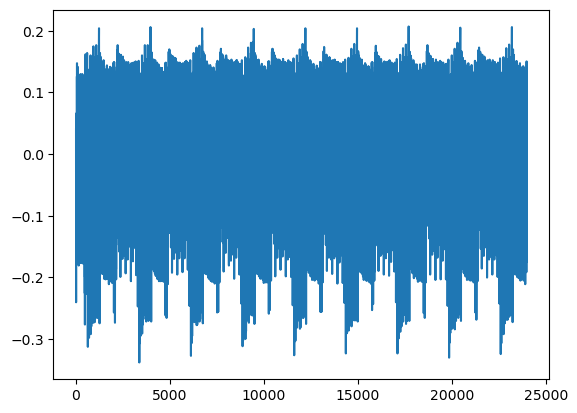

In [20]:
scope.adc.samples = 24000
scope.adc.decimate = 1
# arm the scope to be ready for acquistions
scope.arm()
# the command 'p' includes a signal at the beginning of AES encryption that is sent to the scope to begin acquisition
secret_cipher(plaintext)
ret = scope.capture()
wave = scope.get_last_trace()
plt.figure()
plt.plot(wave)
plt.show()

2. Plot only the first round 

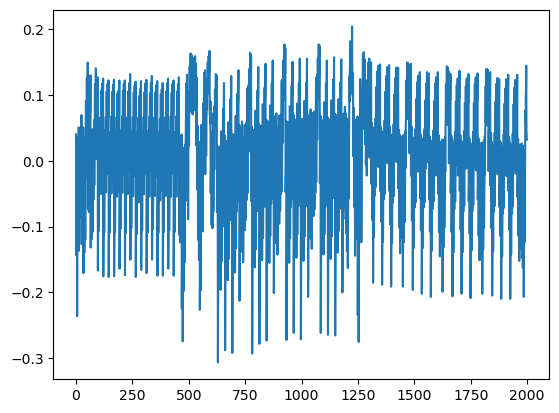

In [21]:
scope.adc.samples = 2000 #to get just the first round
scope.adc.decimate = 1
# arm the scope to be ready for acquistions
scope.arm()
# the command 'p' includes a signal at the beginning of AES encryption that is sent to the scope to begin acquisition
secret_cipher(plaintext)
ret = scope.capture()
wave = scope.get_last_trace()
plt.plot(wave)
plt.show()

#### Acquistion of traces/plaintexts
 -  acquire 2000 sets of (trace/plaintext). The function `acquire_traces` is already written.

In [22]:
def acquire_traces(count=10):
    '''probe : array [scope, channel]
    count: number of curves to save
    returns plaintexts, trace
    '''    
    plaintexts = []
    traces = np.zeros((count, scope.adc.samples), dtype=float)

    for i in tnrange(count, desc = "Capturing"):
        plaintext = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)
        plaintexts.append(plaintext)
        scope.arm()

        secret_cipher(plaintext)
        ret = scope.capture()
        if ret:
            print("Target timed out!")
            continue
        else:
            trace = scope.get_last_trace()
            traces[i] = trace
            
        #scope.stop()
    return traces, plaintexts

tr,pl = acquire_traces(2000)

/tmp/ipykernel_3766/3356546499.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(count, desc = "Capturing"):


Capturing:   0%|          | 0/2000 [00:00<?, ?it/s]

In [23]:
import os
dir_name = "acqui/"
try:
    os.mkdir(dir_name)
    np.save(dir_name + './tracesAES', tr)
    np.save(dir_name + '/plaintexts', pl)
    print("New files correctly saved")
except:
    # in order to avoid erasing traces
    print("Directory already created, delete it before saving new files.")

Directory already created, delete it before saving new files.


In [24]:
# AES SBOX as an array
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5,
    0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0,
    0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc,
    0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a,
    0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0,
    0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
    0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85,
    0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5,
    0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17,
    0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88,
    0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c,
    0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9,
    0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6,
    0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e,
    0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94,
    0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68,
    0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16], dtype=int)

In case you lose or modify the variables traces / plaintexts, you can retrieve them by executing the following cell. It recovers all data by reading the saved files. 

In [25]:
# load traces
traces_exp = np.load("./acqui/tracesAES.npy")
plaintexts_exp = np.load("./acqui/plaintexts.npy")

traces_simu = np.load("./simu/traces_simu.npy")
plaintexts_simu  = np.load("./simu/plaintexts.npy")

You can check if the traces are correct when plotting few curves.

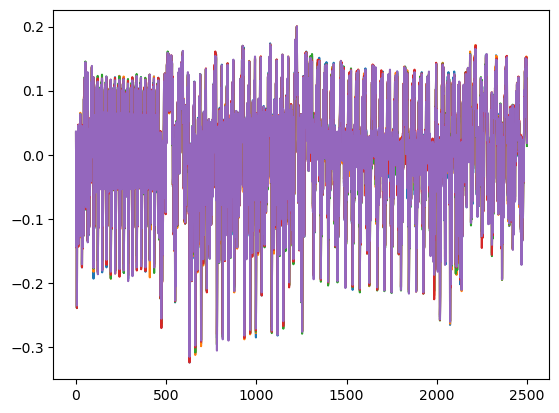

In [26]:
plt.figure()
plt.plot(traces_exp[:5].T)
plt.show()

You can also have a look at the first plaintexts.

In [27]:
print (plaintexts_simu[:5])

[[252 216  49  40 223 127 209  53 118 251  73 247  29 175  38 102]
 [ 78 177  11   7 157  75  32   1 138 103  10 230  81  13  55  70]
 [ 29 152   2 228  96 179 196  80 236 132 236  99  75 162   3 146]
 [235  94  68 113 227  75  15  94 170 233 165 221 177 157 233 255]
 [134  77 234 121  60 150 154 216 214 192  37  80  97 236  32  92]]


### Choose the dataset: simulation or experimental

In order to quickly debug, we advise to first use the simulation sets (`traces_simu` and `plaintexts_simu`). The number of curves ands samples are smaller in this set. When all the DPA attack is validated for this set, you can switch to the real-experimental traces to retrieve the key by modifying the following cell. 

In [28]:
traces = traces_simu
messages = plaintexts_simu
#traces = traces_exp
#messages = plaintexts_exp

### Target + Leakage model : Selection function
The selection function (aka *target function*) is a function which depends on a secret (a key for instance) and a known value (message/plaintext/ciphertext):

- first, you need to write a target function - for example, you can consider the output `byte_i` of the first SBOX
- second, you need to write the DPA simple leakage model: from a byte chose
- write a typical selection function for DPA, which shall return (0,1) and depends $j^{th}$ bit (`bit_j`) output of an AES state (`byte_i`) after the first SubBytes and then choose the position.

## DPA attacks

The attack will target the values after the first SBox, which depends on the plaintext and the key. These values shall be separated into 2 parts, hence the Differential name of this attack, by a predefined `selection` function. In our case, we will select 1 bit of this value. This is the bit where the physical leakage is expected.

There are 16 different byte position in an AES state so we will need 16 independant DPA attack to recover the whole key. 
![Using the outbput of the first SBOX as a selection function](images/selection_target.PNG)

### Questions
1. Determine the `target` function which calculate the intermediate value for a given plaintext, key and byte position

In [29]:
# returns the output values after the first SBOX 
def target_function(msg, key, byte_i):
    ''' msg: 16 byte AES plaintext
        key: 16 bytes AES key
        byte_i:  byte position
        returns: 1 byte at the output of first SBOX
    '''
    if(byte_i>=0 and byte_i<16):
        return SBOX[ key[byte_i] ^ msg[byte_i] ]
    else:
        print("byte_i is not in the good range")
        return -1


2. Determine the `selection` function, which returns (0,1) the value of `bit_j` of the target function with `byte_i`. You can use an intermediate leakage function which is already written.    
3. The selection function we will use in the attack is `sel_0` which target the first bit.  

In [30]:
# returns the value of bit_j of a byte
def leakage_function(byte_i, bit_j):
    ''' byte: 
        bit: 
        returns: 0/1 
    '''
    return (byte_i >> bit_j) & 1
 

def selection(msg, key, byte_i, bit_j):
    
    
    return leakage_function(target_function(msg, key, byte_i), bit_j)


    
# sel0 is selection  with bit_j = 0 
# this function will be used fo further attacks
def sel0(msg, key, byte_i):
    ## fill in
    return selection(msg,key,byte_i,0)

### Attack


Knowing the plaintext, if you guess a byte of the key, you can determine the value of the selection function and choose in which set the trace is.  If this is the correct key, there will a statistical difference between the 2 sets, that you can calculate. 
![Computing differential t](images/selection_function.PNG)


You can calculate this `hypothesis` trace (in red on the Figure) for every key guess. The higher value of this `hypothesis` will correspond the more likely key.  

The whole algorithm to recover a byte of the key - already seen during the lectures - can be summarized below:

```
    For each key_guess :                                                        # among 256 possibilities
        For each (trace, plaintext)
            Compute selection_function(key_guess, plaintext)
            Store the trace in the correct set according to selection_output 
        Compute the differential trace of the 2 sets 
```
Take care that the 2 sets will not have same cardinal (number of elements) so be sure to normalize the 2 sets by the number of elements. 

We can now find the guess which has the highest peak : it is the **most likely key**.

### Questions:
1. For a key `guess`, construct the `hypothesis` vector for every couple (`traces`, `messages`).

In [31]:
def hypothesis(guess, messages, traces, selection_function):
    '''guess: key for this hypothesis
    messages: vector of n values 
    traces: matrix of traces (n . t)
    selection_function: a funtion which takes (m, k) as inputs and returns (0,1). You can use a lambda function derived from 
        the sel0 function
    returns hypothesis(vector)
    '''

    h_0 = np.zeros(len(traces[0]), dtype = np.float64)
    h_1 = np.zeros(len(traces[0]), dtype = np.float64)
    
    cpth_0,cpth_1=0,0;
    
    for message, trace in zip(messages, traces):
        selection_output = selection_function(message, guess)
        if selection_output == 0:
            h_0 += trace
            cpth_0 +=1
        else:
            h_1 += trace
            cpth_1 +=1
    # calculate result
    return abs(h_0/cpth_0 - h_1/cpth_1)

2. Plot this hypothesis vector for simulated traces and key guess 0, on byte 0 and compare with key guess 0xC1. Comment the result.

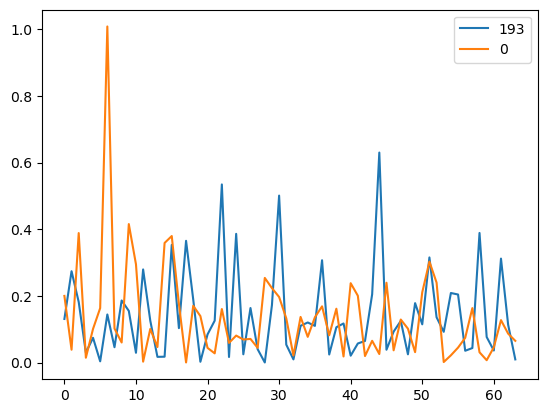

In [32]:
guess = 16*[0xC1]
res = hypothesis(guess, messages, traces, lambda m, g: sel0(m, g,  0))
plt.plot(res, label = str(guess[0]))
guess = 16*[0x00]
res = hypothesis(guess, messages, traces, lambda m, g: sel0(m, g,  0))
plt.plot(res, label = str(guess[0]))
plt.legend()
plt.show()

In [33]:
    #As we can see the guess of the first byte when it s 16*[0x00] is the right one as it gives as a high pic

3. Construct the resulting matrix h for every key guesses and plot it. 

In [34]:
def dpa(guesses, messages, traces, selection_function):
        num_guesses = len(guesses)
        num_traces = len(traces)
        hypothesis_matrix = np.zeros((num_guesses, len(traces[0])), dtype=np.float64)

        for idx, guess in enumerate(guesses):
            hypothesis_matrix[idx] = hypothesis(guess, messages, traces, selection_function)
    
        return hypothesis_matrix ## matrix of 256 hypothesis vectors

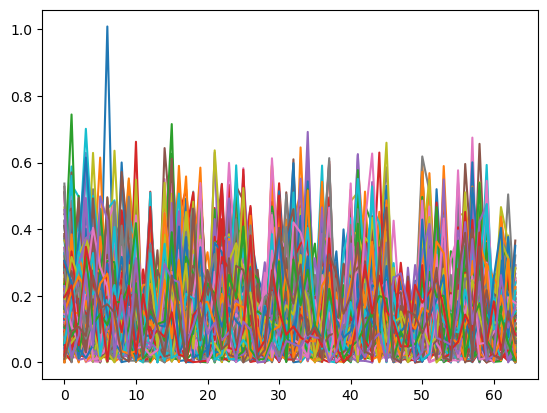

In [35]:
# we need to generate the guesses


guesses=[]
for byte_value in range(256):
    guess = [byte_value] + [0x00] * 15
    guesses.append(guess)

plt.figure()

hypothesis_matrix=dpa(guesses, messages, traces,lambda m, g: sel0(m, g,  0) )
plt.plot(dpa(guesses, messages, traces,lambda m, g: sel0(m, g,  0) ).T)
plt.show()

4. Determine a criteria to find the correct key byte 0 and find this first key byte. 

In [36]:
maximum_indexes=np.array([np.argmax(vec) for vec in hypothesis_matrix])
maximums = np.array([vec.max() for vec in hypothesis_matrix])
max_trace_index = np.argmax(maximums)
correct_key= guesses[np.argmax(maximums)]

print("correct first byte of the key:",correct_key )

correct first byte of the key: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


5. Retrieve every key byte and find the final key.

In [37]:
key = ""
to_plot = []
time_pos = []
nb_traces = 1000

guesses=[np.array(16*[i]) for i in range(256) ]
for pos in range(16):
    h1=dpa(guesses, messages, traces,lambda m, g: selection(m, g, pos, 0) )
    maximum_indexes=np.array([np.argmax(vec) for vec in h1])
    maximums = np.array([vec.max() for vec in h1])
    max_trace_index = np.argmax(maximums)
    time_pos.append(maximum_indexes[max_trace_index])
    key_byte = guesses[max_trace_index][0]
    key += "{:02x}".format(key_byte)
    print("key_"+ str(pos) + " = " + key)


key_0 = 00
key_1 = 0001
key_2 = 000102
key_3 = 00010203
key_4 = 0001020304
key_5 = 0001020304ca
key_6 = 0001020304cafe
key_7 = 0001020304cafe07
key_8 = 0001020304cafe07de
key_9 = 0001020304cafe07dec0
key_10 = 0001020304cafe07dec00d
key_11 = 0001020304cafe07dec00ded
key_12 = 0001020304cafe07dec00ded0c
key_13 = 0001020304cafe07dec00ded0c0d
key_14 = 0001020304cafe07dec00ded0c0d0e
key_15 = 0001020304cafe07dec00ded0c0d0e0f


## Further investigations

1. Find the time position of the leakage for every key byte. 

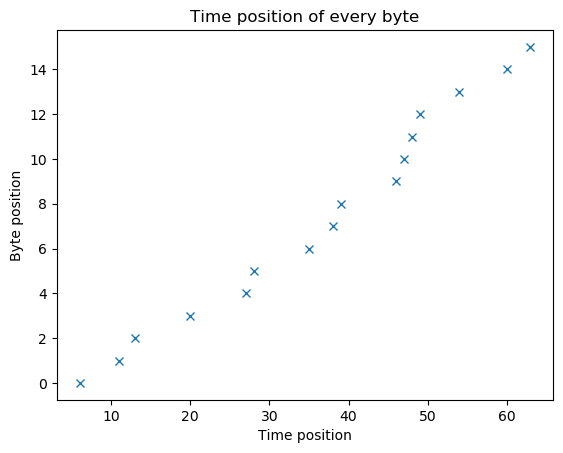

In [38]:
plt.plot(time_pos, list(range(16)), 'x')
plt.xlabel("Time position")
plt.ylabel("Byte position")
plt.title("Time position of every byte")
plt.show()

### Determine how many curves are needed to retrieve a key byte, or the whole key.

1. Rank the key, knowing the correct one, after `nb_traces`.

In [39]:
def rank_array(correct_key, nb_traces):
    correct_key_byte = correct_key[pos]
    guesses= [np.array(16*[i]) for i in range (256)]
    picked_traces = traces[:nb_traces]
    h=dpa(guesses,messages,picked_traces,lambda m, g: selection(m,g,pos, 0) )
    maximums = np.array([vec.max() for vec in h])
    maximums_indexes = np.argsort(maximums)[::-1]
    rank = np.where(maximums_indexes == correct_key_byte)[0][0]
    return rank
    
      

2. Calculate the minimum number of traces to find the first byte of the key

In [40]:
correct_key = [i for i in range(16)]
pl =[]
mi, ma, step = 1, 1000, 5
for i in tnrange(mi, ma, step, desc = "Capturing"):
    
    pl.append(rank_array(correct_key, i))


/tmp/ipykernel_3766/2273562698.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(mi, ma, step, desc = "Capturing"):


Capturing:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_3766/1398288909.py:24: RuntimeWarning: invalid value encountered in divide
  return abs(h_0/cpth_0 - h_1/cpth_1)


3. Plot the correct key rank with an increasing number of traces.

1000


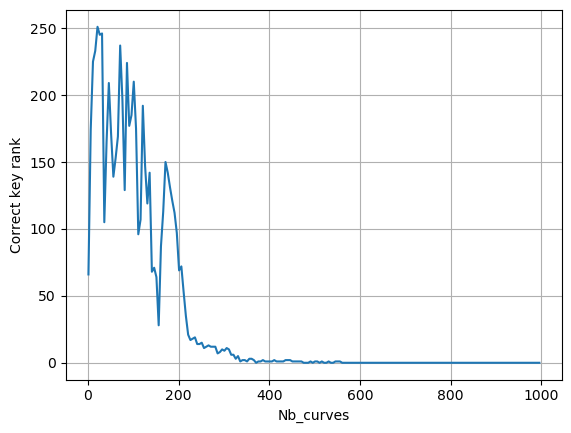

In [41]:
print(len(traces))
plt.figure()
plt.plot(range(mi,ma,step),pl)
plt.xlabel("Nb_curves")
plt.ylabel("Correct key rank")
plt.grid()
plt.show()

4. Attack another part of the algorithm, for instance the first AddRoundKey

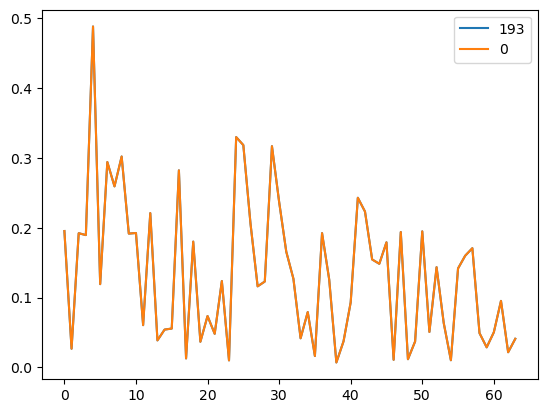

In [49]:
def target_function_ark(msg, key, byte_i):
    ''' msg: 16 byte AES plaintext
        key: 16 bytes AES key
        byte_i:  byte position
        returns: 1 byte at the output of first SBOX
    '''
    if(byte_i>=0 and byte_i<16):
        return key[byte_i] ^ msg[byte_i]
    else:
        print("byte_i is not in the good range")
        return -1

def selection_ark(msg, key, byte_i, bit_j):
    return leakage_function(target_function_ark(msg, key, byte_i), bit_j)


    
# sel0 is selection  with bit_j = 0 
# this function will be used fo further attacks
def sel0_ark(msg, key, byte_i):
    ## fill in
    return selection_ark(msg,key,byte_i,0)

# for two guesses 
guess = 16*[0xC1]
res = hypothesis(guess, messages, traces, lambda m, g: sel0_ark(m, g,  0))
plt.plot(res, label = str(guess[0]))
guess = 16*[0x00]
res = hypothesis(guess, messages, traces, lambda m, g: sel0_ark(m, g,  0))
plt.plot(res, label = str(guess[0]))
plt.legend()
plt.show()





In [ ]:

# we need to generate the guesses


guesses=[]
for byte_value in range(256):
    guess = [byte_value] + [0x00] * 15
    guesses.append(guess)

plt.figure()
plt.plot(dpa(guesses, messages, traces,lambda m, g: sel0_ark(m, g,  0) ).T)
plt.show()

hypothesis_matrix=dpa(guesses, messages, traces,lambda m, g: sel0_ark(m, g,  0) )

maximum_indexes=np.array([np.argmax(vec) for vec in hypothesis_matrix])
maximums = np.array([vec.max() for vec in hypothesis_matrix])
max_trace_index = np.argmax(maximums)
correct_key= guesses[np.argmax(maximums)]

print("correct first byte of the key:",correct_key )



In [45]:
key = ""
to_plot = []
time_pos = []
nb_traces = 1000

guesses=[np.array(16*[i]) for i in range(256) ]
for pos in range(16):
    h1=dpa(guesses, messages, traces,lambda m, g: selection_ark(m, g, pos, 0) )
    maximum_indexes=np.array([np.argmax(vec) for vec in h1])
    maximums = np.array([vec.max() for vec in h1])
    max_trace_index = np.argmax(maximums)
    time_pos.append(maximum_indexes[max_trace_index])
    key_byte = guesses[max_trace_index][0]
    key += "{:02x}".format(key_byte)
    print("key_"+ str(pos) + " = " + key)

key_0 = 00
key_1 = 0000
key_2 = 000000
key_3 = 00000000
key_4 = 0000000000
key_5 = 000000000000
key_6 = 00000000000000
key_7 = 0000000000000000
key_8 = 000000000000000000
key_9 = 00000000000000000000
key_10 = 0000000000000000000000
key_11 = 000000000000000000000000
key_12 = 00000000000000000000000000
key_13 = 0000000000000000000000000000
key_14 = 000000000000000000000000000000
key_15 = 00000000000000000000000000000000


In [51]:
#We notice that it doesn't work because everything is linear, and in our previous analysis we compared linear with non linear elements.